In [ ]:
import os, glob, numpy as np, pandas as pd, kagglehub, torch, torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# ------------------------------------------------------------
# 1. Download dataset
# ------------------------------------------------------------
path = kagglehub.dataset_download("hyelinnam/vic-dataset-iq-signal-visualization-for-cbrs")
print("Dataset path:", path)

iq_files = sorted(glob.glob(os.path.join(path, "**", "*.csv"), recursive=True))
print("Num CSV files:", len(iq_files))


# ------------------------------------------------------------
# 2. Metadata parser
# ------------------------------------------------------------
def parse_metadata(filepath):
    dirname = os.path.basename(os.path.dirname(filepath))
    parts = dirname.split("_")

    device = 0
    band   = 0
    chan   = 0

    if len(parts) >= 3:
        try: device = int(parts[0].replace("D","").replace("dev",""))
        except: pass
        try: band = int(parts[1].replace("B","").replace("band",""))
        except: pass
        try: chan = int(parts[2].replace("C","").replace("ch","").replace("chan",""))
        except: pass

    return np.array([device, band, chan], dtype=np.float32)


# ------------------------------------------------------------
# 3. Load IQ + compute FFT's at 1024, 512, 256
# ------------------------------------------------------------
def load_iq_csv(fp, seq_len=1024):
    df = pd.read_csv(fp)
    if "I" in df.columns and "Q" in df.columns:
        iq = df[["I","Q"]].values.astype(np.float32)
    else:
        iq = df.values[:, :2].astype(np.float32)

    if len(iq) >= seq_len:
        iq_seq = iq[:seq_len]
    else:
        out = np.zeros((seq_len,2), np.float32)
        out[:len(iq)] = iq
        iq_seq = out

    # Unit power normalization
    power = np.mean(iq_seq[:,0]**2 + iq_seq[:,1]**2)
    power = max(power, 1e-12)
    iq_seq = iq_seq / np.sqrt(power)

    snr = 10.0 * np.log10(power)

    # FFT 1024
    fft_1024 = np.abs(np.fft.fft(iq_seq[:,0] + 1j*iq_seq[:,1])).astype(np.float32)

    # FFT 512
    fft_512 = fft_1024[:512]

    # FFT 256
    fft_256 = fft_1024[:256]

    # Metadata
    meta = parse_metadata(fp)

    return iq_seq, fft_1024, fft_512, fft_256, snr, meta


# ------------------------------------------------------------
# 4. Load entire dataset
# ------------------------------------------------------------
X_raw = []
FFT1024_raw = []
FFT512_raw  = []
FFT256_raw  = []
SNRs        = []
META        = []
y           = []

for fp in iq_files:
    label = os.path.basename(os.path.dirname(fp))
    seq, f1024, f512, f256, snr, meta = load_iq_csv(fp)
    X_raw.append(seq)
    FFT1024_raw.append(f1024)
    FFT512_raw.append(f512)
    FFT256_raw.append(f256)
    SNRs.append(snr)
    META.append(meta)
    y.append(label)

X_raw = np.stack(X_raw)
FFT1024_raw = np.stack(FFT1024_raw)
FFT512_raw  = np.stack(FFT512_raw)
FFT256_raw  = np.stack(FFT256_raw)
SNRs = np.array(SNRs, dtype=np.float32).reshape(-1,1)
META = np.stack(META)
y = np.array(y)

labels = sorted(list(set(y)))
label_to_idx = {l:i for i,l in enumerate(labels)}
y_idx = np.array([label_to_idx[a] for a in y], dtype=np.int64)

print("Dataset shapes:")
print("IQ:", X_raw.shape)
print("FFT1024:", FFT1024_raw.shape)
print("FFT512:", FFT512_raw.shape)
print("FFT256:", FFT256_raw.shape)
print("META:", META.shape)
print("Classes:", labels)


# ------------------------------------------------------------
# 5. Standardize metadata
# ------------------------------------------------------------
scaler_meta = StandardScaler()
META_scaled = scaler_meta.fit_transform(META)


# ------------------------------------------------------------
# 6. Train/val split
# ------------------------------------------------------------
from sklearn.model_selection import train_test_split

(
    X_train, X_val,
    FFT1024_train, FFT1024_val,
    FFT512_train, FFT512_val,
    FFT256_train, FFT256_val,
    SNR_train, SNR_val,
    META_train, META_val,
    y_train, y_val
) = train_test_split(
    X_raw, FFT1024_raw, FFT512_raw, FFT256_raw, SNRs, META_scaled, y_idx,
    test_size=0.2, random_state=42, stratify=y_idx
)

device = "cuda" if torch.cuda.is_available() else "cpu"

X_train_t = torch.tensor(X_train, device=device).float()
X_val_t   = torch.tensor(X_val, device=device).float()

F1024_train_t = torch.tensor(FFT1024_train, device=device).float()
F1024_val_t   = torch.tensor(FFT1024_val, device=device).float()

F512_train_t = torch.tensor(FFT512_train, device=device).float()
F512_val_t   = torch.tensor(FFT512_val, device=device).float()

F256_train_t = torch.tensor(FFT256_train, device=device).float()
F256_val_t   = torch.tensor(FFT256_val, device=device).float()

SNR_train_t = torch.tensor(SNR_train, device=device).float()
SNR_val_t   = torch.tensor(SNR_val, device=device).float()

META_train_t = torch.tensor(META_train, device=device).float()
META_val_t   = torch.tensor(META_val, device=device).float()

y_train_t = torch.tensor(y_train, device=device).long()
y_val_t   = torch.tensor(y_val, device=device).long()


# ------------------------------------------------------------
# 7. Transformer-based model
# ------------------------------------------------------------
class CNN_Transformer_Fusion(nn.Module):
    def __init__(self, classes):
        super().__init__()

        # CNN for IQ (temporal feature extractor)
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Transformer encoder (2 layers)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=8,
            dim_feedforward=512,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # FFT branches
        self.fft1024_fc = nn.Sequential(nn.Linear(1024, 256), nn.ReLU())
        self.fft512_fc  = nn.Sequential(nn.Linear(512, 128), nn.ReLU())
        self.fft256_fc  = nn.Sequential(nn.Linear(256,  96), nn.ReLU())

        # Metadata + SNR
        self.meta_fc = nn.Sequential(nn.Linear(1 + 3, 32), nn.ReLU())

        # Final fusion
        fusion_dim = 128 + 256 + 128 + 96 + 32
        self.fc = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Linear(256, classes)
        )

    def forward(self, iq, f1024, f512, f256, snr, meta):

        # CNN path
        x = iq.permute(0,2,1)
        x = self.cnn(x)
        x = x.permute(0,2,1)

        # Transformer
        x = self.transformer(x)
        trans_feat = x[:, -1]

        # FFT branches
        fft1024_feat = self.fft1024_fc(f1024)
        fft512_feat  = self.fft512_fc(f512)
        fft256_feat  = self.fft256_fc(f256)

        # Metadata
        meta_all = torch.cat([snr, meta], dim=1)
        meta_feat = self.meta_fc(meta_all)

        # Fuse everything
        fused = torch.cat([
            trans_feat,
            fft1024_feat,
            fft512_feat,
            fft256_feat,
            meta_feat
        ], dim=1)

        return self.fc(fused)


model = CNN_Transformer_Fusion(classes=len(labels)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    mode="max",
    factor=0.5,
    patience=3
)

def print_lr(opt):
    print("LR:", opt.param_groups[0]["lr"])


# ------------------------------------------------------------
# 8. Training loop
# ------------------------------------------------------------
train_acc_hist = []
val_acc_hist   = []

best_val = 0.0
best_state = None
patience = 10
wait = 0

epochs = 40
batch_size = 64

def train_epoch():
    model.train()
    idx = torch.randperm(len(X_train_t))
    correct = 0
    total = 0
    for i in range(0, len(X_train_t), batch_size):
        sel = idx[i:i+batch_size]
        opt.zero_grad()
        pred = model(
            X_train_t[sel],
            F1024_train_t[sel],
            F512_train_t[sel],
            F256_train_t[sel],
            SNR_train_t[sel],
            META_train_t[sel]
        )
        loss = loss_fn(pred, y_train_t[sel])
        loss.backward()
        opt.step()
        correct += (pred.argmax(1) == y_train_t[sel]).sum().item()
        total   += len(sel)
    return correct/total


def eval_epoch():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(0, len(X_val_t), batch_size):
            pred = model(
                X_val_t[i:i+batch_size],
                F1024_val_t[i:i+batch_size],
                F512_val_t[i:i+batch_size],
                F256_val_t[i:i+batch_size],
                SNR_val_t[i:i+batch_size],
                META_val_t[i:i+batch_size]
            )
            correct += (pred.argmax(1) == y_val_t[i:i+batch_size]).sum().item()
            total   += len(pred)
    return correct/total


for ep in range(1, epochs+1):
    tr = train_epoch()
    va = eval_epoch()

    train_acc_hist.append(tr)
    val_acc_hist.append(va)

    print(f"Epoch {ep:02d}: Train={tr:.4f}  Val={va:.4f}")
    print_lr(opt)

    prev_lr = opt.param_groups[0]["lr"]
    scheduler.step(va)
    new_lr = opt.param_groups[0]["lr"]
    if new_lr != prev_lr:
        print("LR changed:", prev_lr, "->", new_lr)

    if va > best_val:
        best_val = va
        best_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

if best_state is not None:
    model.load_state_dict(best_state)

print("Best Val Accuracy:", best_val)


# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(train_acc_hist, label="Train")
plt.plot(val_acc_hist, label="Val")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN + Transformer + Multi-resolution FFT + Metadata")
plt.legend()
plt.show()


# ------------------------------------------------------------
# Confusion matrix
# ------------------------------------------------------------
model.eval()
pred_all = []

with torch.no_grad():
    for i in range(len(X_val_t)):
        p = model(
            X_val_t[i:i+1],
            F1024_val_t[i:i+1],
            F512_val_t[i:i+1],
            F256_val_t[i:i+1],
            SNR_val_t[i:i+1],
            META_val_t[i:i+1]
        ).argmax(1).item()
        pred_all.append(p)

cm = confusion_matrix(y_val, pred_all)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma",
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Dataset path: /home/rameyjm7/.cache/kagglehub/datasets/hyelinnam/vic-dataset-iq-signal-visualization-for-cbrs/versions/1
Num CSV files: 49194
Dataset shapes:
IQ: (49194, 1024, 2)
FFT1024: (49194, 1024)
FFT512: (49194, 512)
FFT256: (49194, 256)
META: (49194, 3)
Classes: [np.str_('3.555-Chirp_2'), np.str_('3.555-Chirp_3'), np.str_('3.565-Chirp_3'), np.str_('3.565-Chirp_4'), np.str_('Chirp_1'), np.str_('Chirp_2')]
Epoch 01: Train=0.5370  Val=0.5618
LR: 0.001
Epoch 02: Train=0.6154  Val=0.6287
LR: 0.001
Epoch 03: Train=0.6494  Val=0.6517
LR: 0.001
Epoch 04: Train=0.6715  Val=0.6622
LR: 0.001
Epoch 05: Train=0.6835  Val=0.6658
LR: 0.001
Epoch 06: Train=0.6983  Val=0.6788
LR: 0.001
Epoch 07: Train=0.7047  Val=0.6905
LR: 0.001
Epoch 08: Train=0.7137  Val=0.6803
LR: 0.001
Epoch 09: Train=0.7261  Val=0.6786
LR: 0.001
Epoch 10: Train=0.7277  Val=0.6755
LR: 0.001
Epoch 11: Train=0.7353  Val=0.7026
LR: 0.001
Epoch 12: Train=0.7411  Val=0.6938
LR: 0.001
Epoch 13: Train=0.7460  Val=0.6886
LR: 0.001


Model will be saved to: /home/rameyjm7/workspace/MachineLearning-Sandbox/models/vic_cnn_deepbilstm_attention.keras
Dataset path: /home/rameyjm7/.cache/kagglehub/datasets/hyelinnam/vic-dataset-iq-signal-visualization-for-cbrs/versions/1
Num CSV files: 49194
Shapes:
IQ: (49194, 1024, 2)
FFT1024: (49194, 1024)
FFT512: (49194, 512)
FFT256: (49194, 256)
META: (49194, 3)
Epoch 01: Train=0.5257  Val=0.6070
LR: 0.001
Epoch 02: Train=0.6139  Val=0.6359
LR: 0.001
Epoch 03: Train=0.6491  Val=0.6534
LR: 0.001
Epoch 04: Train=0.6734  Val=0.6758
LR: 0.001
Epoch 05: Train=0.6880  Val=0.6892
LR: 0.001
Epoch 06: Train=0.7064  Val=0.6899
LR: 0.001
Epoch 07: Train=0.7140  Val=0.6617
LR: 0.001
Epoch 08: Train=0.7182  Val=0.6707
LR: 0.001
Epoch 09: Train=0.7261  Val=0.6975
LR: 0.001
Epoch 10: Train=0.7330  Val=0.6953
LR: 0.001
Epoch 11: Train=0.7369  Val=0.6940
LR: 0.001
Epoch 12: Train=0.7401  Val=0.6971
LR: 0.001
Epoch 13: Train=0.7486  Val=0.6813
LR: 0.001
LR changed: 0.001 -> 0.0005
Epoch 14: Train=0.7

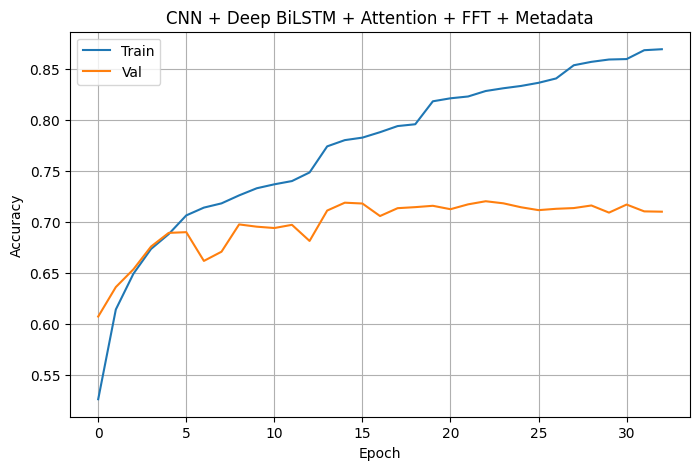

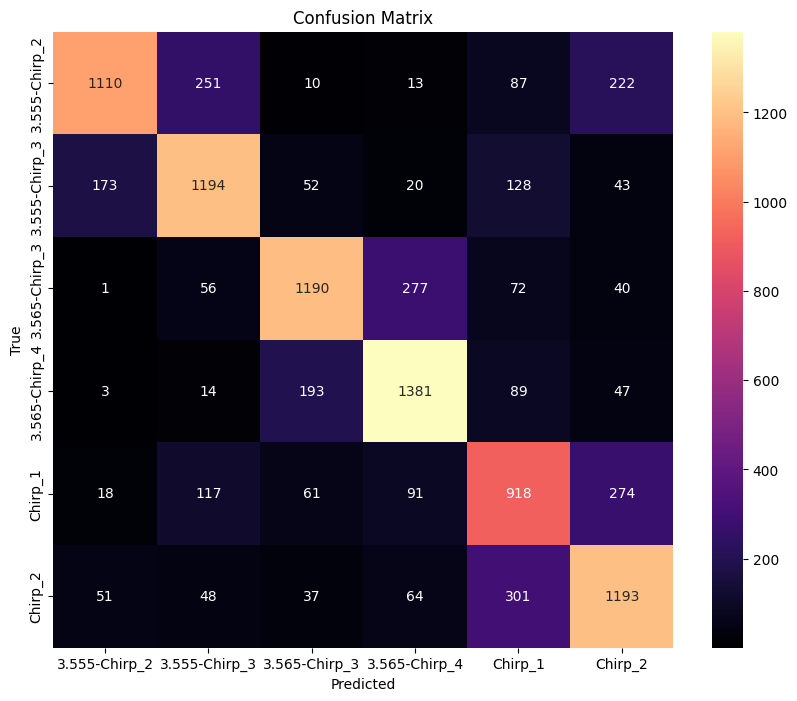

In [1]:
import os, glob, numpy as np, pandas as pd, kagglehub, torch, torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# ------------------------------------------------------------
# Resolve project paths and model output directory
# ------------------------------------------------------------
notebook_dir = Path().resolve()
project_root = notebook_dir.parent
models_dir = project_root / "models"
models_dir.mkdir(exist_ok=True)
model_path = models_dir / "vic_cnn_deepbilstm_attention.keras"
print("Model will be saved to:", model_path)

# ------------------------------------------------------------
# 1. Download dataset
# ------------------------------------------------------------
path = kagglehub.dataset_download("hyelinnam/vic-dataset-iq-signal-visualization-for-cbrs")
print("Dataset path:", path)

iq_files = sorted(glob.glob(os.path.join(path, "**", "*.csv"), recursive=True))
print("Num CSV files:", len(iq_files))

# ------------------------------------------------------------
# 2. Metadata extraction
# ------------------------------------------------------------
def parse_metadata(filepath):
    dirname = os.path.basename(os.path.dirname(filepath))
    parts = dirname.split("_")
    device = 0
    band   = 0
    chan   = 0

    if len(parts) >= 3:
        try: device = int(parts[0].replace("D","").replace("dev",""))
        except: pass
        try: band = int(parts[1].replace("B","").replace("band",""))
        except: pass
        try: chan = int(parts[2].replace("C","").replace("ch","").replace("chan",""))
        except: pass

    return np.array([device, band, chan], dtype=np.float32)

# ------------------------------------------------------------
# 3. Load IQ + FFT1024 + FFT512 + FFT256 + SNR + metadata
# ------------------------------------------------------------
def load_iq_csv(fp, seq_len=1024):
    df = pd.read_csv(fp)
    if "I" in df.columns and "Q" in df.columns:
        iq = df[["I","Q"]].values.astype(np.float32)
    else:
        iq = df.values[:, :2].astype(np.float32)

    if len(iq) >= seq_len:
        iq_seq = iq[:seq_len]
    else:
        out = np.zeros((seq_len,2), np.float32)
        out[:len(iq)] = iq
        iq_seq = out

    # Unit power normalization
    power = np.mean(iq_seq[:,0]**2 + iq_seq[:,1]**2)
    power = max(power, 1e-12)
    iq_seq = iq_seq / np.sqrt(power)

    snr = 10.0 * np.log10(power)

    # FFTs
    fft1024 = np.abs(np.fft.fft(iq_seq[:,0] + 1j*iq_seq[:,1])).astype(np.float32)
    fft512  = fft1024[:512]
    fft256  = fft1024[:256]

    meta = parse_metadata(fp)

    return iq_seq, fft1024, fft512, fft256, snr, meta

# ------------------------------------------------------------
# 4. Load entire dataset
# ------------------------------------------------------------
X_raw = []
FFT1024_raw = []
FFT512_raw  = []
FFT256_raw  = []
SNRs = []
META = []
y = []

for fp in iq_files:
    label = os.path.basename(os.path.dirname(fp))
    seq, f1024, f512, f256, snr, meta = load_iq_csv(fp)
    X_raw.append(seq)
    FFT1024_raw.append(f1024)
    FFT512_raw.append(f512)
    FFT256_raw.append(f256)
    SNRs.append(snr)
    META.append(meta)
    y.append(label)

X_raw = np.stack(X_raw)
FFT1024_raw = np.stack(FFT1024_raw)
FFT512_raw  = np.stack(FFT512_raw)
FFT256_raw  = np.stack(FFT256_raw)
SNRs = np.array(SNRs, dtype=np.float32).reshape(-1,1)
META = np.stack(META)
y = np.array(y)

labels = sorted(list(set(y)))
label_to_idx = {l:i for i,l in enumerate(labels)}
y_idx = np.array([label_to_idx[a] for a in y], dtype=np.int64)

print("Shapes:")
print("IQ:", X_raw.shape)
print("FFT1024:", FFT1024_raw.shape)
print("FFT512:", FFT512_raw.shape)
print("FFT256:", FFT256_raw.shape)
print("META:", META.shape)

# ------------------------------------------------------------
# 5. Metadata standardization
# ------------------------------------------------------------
scaler_meta = StandardScaler()
META_scaled = scaler_meta.fit_transform(META)

# ------------------------------------------------------------
# 6. Train/val split
# ------------------------------------------------------------
from sklearn.model_selection import train_test_split

(
    X_train, X_val,
    F1024_train, F1024_val,
    F512_train, F512_val,
    F256_train, F256_val,
    SNR_train, SNR_val,
    META_train, META_val,
    y_train, y_val
) = train_test_split(
    X_raw, FFT1024_raw, FFT512_raw, FFT256_raw, SNRs, META_scaled, y_idx,
    test_size=0.2, random_state=42, stratify=y_idx
)

device = "cuda" if torch.cuda.is_available() else "cpu"

X_train_t  = torch.tensor(X_train, device=device).float()
X_val_t    = torch.tensor(X_val,   device=device).float()
F1024_tr_t = torch.tensor(F1024_train, device=device).float()
F1024_va_t = torch.tensor(F1024_val,   device=device).float()
F512_tr_t  = torch.tensor(F512_train,  device=device).float()
F512_va_t  = torch.tensor(F512_val,    device=device).float()
F256_tr_t  = torch.tensor(F256_train,  device=device).float()
F256_va_t  = torch.tensor(F256_val,    device=device).float()
SNR_tr_t   = torch.tensor(SNR_train,   device=device).float()
SNR_va_t   = torch.tensor(SNR_val,     device=device).float()
META_tr_t  = torch.tensor(META_train,  device=device).float()
META_va_t  = torch.tensor(META_val,    device=device).float()
y_train_t  = torch.tensor(y_train,     device=device).long()
y_val_t    = torch.tensor(y_val,       device=device).long()

# ------------------------------------------------------------
# 7. Deep BiLSTM + Self-Attention model
# ------------------------------------------------------------
class Attention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.att = nn.Linear(dim, 1)

    def forward(self, x):
        w = self.att(x)
        w = torch.softmax(w, dim=1)
        return (x * w).sum(dim=1)

class CNN_DeepBiLSTM_Attention(nn.Module):
    def __init__(self, classes):
        super().__init__()

        # CNN front-end
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU()
        )

        # Deep BiLSTM
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=128,
            num_layers=3,
            batch_first=True,
            bidirectional=True
        )

        # Self-Attention on LSTM outputs
        self.attn = Attention(dim=256)

        # FFT branches
        self.fft1024_fc = nn.Sequential(nn.Linear(1024, 256), nn.ReLU())
        self.fft512_fc  = nn.Sequential(nn.Linear(512, 128), nn.ReLU())
        self.fft256_fc  = nn.Sequential(nn.Linear(256, 96),  nn.ReLU())

        # Metadata + SNR
        self.meta_fc = nn.Sequential(nn.Linear(1 + 3, 32), nn.ReLU())

        # Final classifier
        fusion_dim = 256 + 256 + 128 + 96 + 32
        self.fc = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Linear(256, classes)
        )

    def forward(self, iq, f1024, f512, f256, snr, meta):

        x = iq.permute(0,2,1)
        x = self.cnn(x)
        x = x.permute(0,2,1)

        lstm_out, _ = self.lstm(x)
        lstm_feat = self.attn(lstm_out)

        f1024_feat = self.fft1024_fc(f1024)
        f512_feat  = self.fft512_fc(f512)
        f256_feat  = self.fft256_fc(f256)

        meta_all = torch.cat([snr, meta], dim=1)
        meta_feat = self.meta_fc(meta_all)

        fused = torch.cat([lstm_feat, f1024_feat, f512_feat, f256_feat, meta_feat], dim=1)
        return self.fc(fused)

model = CNN_DeepBiLSTM_Attention(classes=len(labels)).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="max", factor=0.5, patience=3
)

def print_lr(opt):
    print("LR:", opt.param_groups[0]["lr"])

# ------------------------------------------------------------
# 8. Training loop
# ------------------------------------------------------------
train_acc_hist = []
val_acc_hist = []

best_val = 0.0
best_state = None
patience = 10
wait = 0

epochs = 40
batch = 64

def train_epoch():
    model.train()
    idx = torch.randperm(len(X_train_t))
    correct = 0
    total   = 0
    for i in range(0, len(X_train_t), batch):
        sel = idx[i:i+batch]
        opt.zero_grad()
        pred = model(
            X_train_t[sel],
            F1024_tr_t[sel],
            F512_tr_t[sel],
            F256_tr_t[sel],
            SNR_tr_t[sel],
            META_tr_t[sel]
        )
        loss = loss_fn(pred, y_train_t[sel])
        loss.backward()
        opt.step()
        correct += (pred.argmax(1) == y_train_t[sel]).sum().item()
        total   += len(sel)
    return correct/total

def eval_epoch():
    model.eval()
    correct = 0
    total   = 0
    with torch.no_grad():
        for i in range(0, len(X_val_t), batch):
            pred = model(
                X_val_t[i:i+batch],
                F1024_va_t[i:i+batch],
                F512_va_t[i:i+batch],
                F256_va_t[i:i+batch],
                SNR_va_t[i:i+batch],
                META_va_t[i:i+batch]
            )
            correct += (pred.argmax(1) == y_val_t[i:i+batch]).sum().item()
            total   += len(pred)
    return correct/total

for ep in range(1, epochs+1):
    tr = train_epoch()
    va = eval_epoch()

    train_acc_hist.append(tr)
    val_acc_hist.append(va)

    print(f"Epoch {ep:02d}: Train={tr:.4f}  Val={va:.4f}")
    print_lr(opt)

    prev_lr = opt.param_groups[0]["lr"]
    scheduler.step(va)
    new_lr = opt.param_groups[0]["lr"]
    if new_lr != prev_lr:
        print("LR changed:", prev_lr, "->", new_lr)

    if va > best_val:
        best_val = va
        best_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

if best_state is not None:
    model.load_state_dict(best_state)

print("Best Val Accuracy:", best_val)

# ------------------------------------------------------------
# 9. Save model
# ------------------------------------------------------------
torch.save(model.state_dict(), model_path)
print("Model saved to:", model_path)

# ------------------------------------------------------------
# 10. Accuracy plot
# ------------------------------------------------------------
plt.figure(figsize=(8,5))
plt.plot(train_acc_hist, label="Train")
plt.plot(val_acc_hist, label="Val")
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN + Deep BiLSTM + Attention + FFT + Metadata")
plt.legend()
plt.show()

# ------------------------------------------------------------
# 11. Confusion Matrix
# ------------------------------------------------------------
model.eval()
pred_all = []
with torch.no_grad():
    for i in range(len(X_val_t)):
        p = model(
            X_val_t[i:i+1],
            F1024_va_t[i:i+1],
            F512_va_t[i:i+1],
            F256_va_t[i:i+1],
            SNR_va_t[i:i+1],
            META_va_t[i:i+1]
        ).argmax(1).item()
        pred_all.append(p)

cm = confusion_matrix(y_val, pred_all)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
